In [1]:
%load_ext autoreload
%autoreload 2

# Selfies Featurization with one hot encoding

In [2]:
import os
from dotenv import load_dotenv
import selfies as sf
from tqdm import tqdm
from selfies import EncoderError
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import json
from collections import deque
import gc




from Code.Utils.util_methods import NNUtils

In [3]:
current_file = os.getcwd()  # or provide a specific file path
try:
    base = NNUtils.find_project_root(current_file)
    print(f"Project root found: {base}")
except FileNotFoundError as e:
    base=None
    print(e)
    
load_dotenv(f'{base}/.env')

Project root found: /SpecToMol


True

In [4]:
# Todo: Set the variables False if not needed
NEW_ORDERED_DICT = True # If a new ordered (by SELFIES part occurence) dictionary should be used, where only the present SELFIES parts are used, instead of the existing dict
NEW_RANDOM_DICT = False # Same but the order of the parts will be random
NORMALIZE_SPECTRA = False # KEEP IT FALSE # If the spectra (X data) should be normalized between 0 and 1

## Load the cleaned data

In [5]:
cleaned_df = NNUtils.read_big_csv(f"{base}/Dataset/Mass_spectra/cleaned_df.csv")
print(cleaned_df.shape)
cleaned_df.head()

Reading CSV file cleaned_df.csv: 7it [00:00, 10.07it/s]

(6007, 609)


,Name,Form,Mw,Cas,mz1,mz2,mz3,mz4,mz5,mz6,...,mz596,mz597,mz598,mz599,mz600,Filter_Form,SMILES,Arom,Filter,filter
0,"2-Pentanone, 3-ethyl-3-methyl-",C8H16O,128,19780-65-5,0,0,0,0,0,0,...,0,0,0,0,0,True,CCC(C)(CC)C(C)=O,0,1,1
1,3-Methyl-3-hexen-2-ol,C7H14O,114,76966-27-3,0,0,0,0,0,0,...,0,0,0,0,0,True,CCC=C(C)C(C)O,0,1,1
2,"Hexane, 1-(3-butenyloxy)-",C10H20O,156,107995-55-1,0,0,0,0,0,0,...,0,0,0,0,0,True,CCCCCCOCCC=C,0,1,1
3,"2-Hexanone, 3,3-dimethyl-",C8H16O,128,26118-38-7,0,0,0,0,0,0,...,0,0,0,0,0,True,CCCC(C)(C)C(C)=O,0,1,1
4,"4-Methyl-1,6-heptadien-4-ol",C8H14O,126,25201-40-5,0,0,0,0,0,0,...,0,0,0,0,0,True,CC(O)(CC=C)CC=C,0,1,1


## Add the selfies 

In [6]:
cleaned_df_selfies = cleaned_df.copy()

# add a new column with SELFIES representation
cleaned_df_selfies = NNUtils.add_selfies_to_df(cleaned_df_selfies)

cleaned_df_selfies.drop(cleaned_df_selfies[cleaned_df_selfies["SELFIES"] == "Invalid"].index, inplace=True)
cleaned_df_selfies.reset_index(drop=True, inplace=True)


# filter rows where SELFIES contains a dot
contains_dot = cleaned_df_selfies["SELFIES"].str.contains(r'\.')
# count the number of SELFIES containing a dot
count_with_dot = contains_dot.sum()
print(f"Number of SELFIES containing a dot: {count_with_dot}")
# remove rows with SELFIES containing a dot
cleaned_df_selfies = cleaned_df_selfies[~cleaned_df_selfies["SELFIES"].str.contains(r'\.')].reset_index(drop=True)


print('Invalid SMILES and SELFIES with a dot removed')
print(cleaned_df_selfies.shape)
cleaned_df_selfies.head()

Adding SELFIES to the dataframe: 100%|██████████| 6007/6007 [00:01<00:00, 3409.24it/s]


Number of invalid SMILES: 0
Number of SELFIES containing a dot: 0
Invalid SMILES and SELFIES with a dot removed
(6007, 610)


,Name,Form,Mw,Cas,mz1,mz2,mz3,mz4,mz5,mz6,...,mz597,mz598,mz599,mz600,Filter_Form,SMILES,Arom,Filter,filter,SELFIES
0,"2-Pentanone, 3-ethyl-3-methyl-",C8H16O,128,19780-65-5,0,0,0,0,0,0,...,0,0,0,0,True,CCC(C)(CC)C(C)=O,0,1,1,[C][C][C][Branch1][C][C][Branch1][Ring1][C][C]...
1,3-Methyl-3-hexen-2-ol,C7H14O,114,76966-27-3,0,0,0,0,0,0,...,0,0,0,0,True,CCC=C(C)C(C)O,0,1,1,[C][C][C][=C][Branch1][C][C][C][Branch1][C][C][O]
2,"Hexane, 1-(3-butenyloxy)-",C10H20O,156,107995-55-1,0,0,0,0,0,0,...,0,0,0,0,True,CCCCCCOCCC=C,0,1,1,[C][C][C][C][C][C][O][C][C][C][=C]
3,"2-Hexanone, 3,3-dimethyl-",C8H16O,128,26118-38-7,0,0,0,0,0,0,...,0,0,0,0,True,CCCC(C)(C)C(C)=O,0,1,1,[C][C][C][C][Branch1][C][C][Branch1][C][C][C][...
4,"4-Methyl-1,6-heptadien-4-ol",C8H14O,126,25201-40-5,0,0,0,0,0,0,...,0,0,0,0,True,CC(O)(CC=C)CC=C,0,1,1,[C][C][Branch1][C][O][Branch1][Ring2][C][C][=C...


## Create a DF with unique SELFIES

In [7]:
selfies_df = cleaned_df_selfies[["SELFIES"]].drop_duplicates().reset_index(drop=True)
print(selfies_df.shape)
selfies_df

(3800, 1)


,SELFIES
0,[C][C][C][Branch1][C][C][Branch1][Ring1][C][C]...
1,[C][C][C][=C][Branch1][C][C][C][Branch1][C][C][O]
2,[C][C][C][C][C][C][O][C][C][C][=C]
3,[C][C][C][C][Branch1][C][C][Branch1][C][C][C][...
4,[C][C][Branch1][C][O][Branch1][Ring2][C][C][=C...
...,...
3795,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...
3796,[C][C][Branch1][C][C][C][C][C][C@@H1][Branch1]...
3797,[C][C][Branch1][C][C][C@H1][C][C][C@H1][C][=C]...
3798,[C][C][=Branch2][Ring1][P][=C][/C][=C][/C][=C]...


## Create a dictionary with each SELFIES component

In [8]:
selfies_group_dict = {}
if NEW_RANDOM_DICT:
    # extract unique SELFIES groups
    unique_selfies_groups = sf.get_alphabet_from_selfies(selfies_df["SELFIES"])

    # create the dictionary with enumerated positions
    selfies_group_dict = {group: idx+1 for idx, group in enumerate(unique_selfies_groups)}
    selfies_group_dict['[nop]'] = 0
selfies_group_dict

{}

In [9]:
if not(NEW_ORDERED_DICT or NEW_RANDOM_DICT):
    # read json file into dictionary
    with open(f'{base}/Code/Full_systems/Selfies_Mol/Featurization/selfies_group_dict.json', 'r') as json_file:
        selfies_group_dict = json.load(json_file)
selfies_group_dict

{}

## Get the frequency of each SELFIES component

In [10]:
# split SELFIES into fragments and count frequencies
all_keys = []
for selfies in selfies_df["SELFIES"]:
    all_keys.extend(selfies.split("]["))  # split on "][" to get individual fragments

# normalize fragments by adding brackets back
normalized_keys = [f"[{key.strip('][')}]" for key in all_keys]

# count frequencies
key_frequencies = Counter(normalized_keys)

# display the frequencies
print(f'There are {len(key_frequencies)+1} different selfies parts')
key_frequencies


There are 35 different selfies parts


Counter({'[C]': 45970,
         '[Branch1]': 6536,
         '[Ring1]': 5681,
         '[=C]': 3417,
         '[O]': 2632,
         '[=Branch1]': 2094,
         '[=O]': 1426,
         '[C@H1]': 1140,
         '[Ring2]': 880,
         '[#Branch1]': 764,
         '[Branch2]': 652,
         '[C@@H1]': 640,
         '[/C]': 625,
         '[C@]': 534,
         '[=Branch2]': 436,
         '[\\C]': 407,
         '[#Branch2]': 297,
         '[#C]': 279,
         '[N]': 273,
         '[S]': 183,
         '[=N]': 154,
         '[C@@]': 132,
         '[P]': 81,
         '[=CH0]': 41,
         '[CH0]': 33,
         '[CH1]': 25,
         '[=CH2]': 14,
         '[CH2]': 13,
         '[=CH1]': 12,
         '[\\C@@H1]': 7,
         '[/O]': 7,
         '[/C@@H1]': 7,
         '[/-Ring1]': 6,
         '[\\-Ring1]': 2})

In [11]:
if NEW_ORDERED_DICT:
    selfies_group_dict = {'[nop]': 0}
    c=0
    for i in key_frequencies:
        c+=1
        selfies_group_dict[i] = c

    with open(f'{base}/Code/Full_systems/Selfies_Mol/Featurization/selfies_group_dict.json', "w") as file:
        json.dump(selfies_group_dict, file, indent=4)
selfies_group_dict

{'[nop]': 0,
 '[C]': 1,
 '[Branch1]': 2,
 '[Ring1]': 3,
 '[=O]': 4,
 '[=C]': 5,
 '[O]': 6,
 '[Ring2]': 7,
 '[=Branch1]': 8,
 '[#C]': 9,
 '[/C]': 10,
 '[#Branch1]': 11,
 '[\\C]': 12,
 '[Branch2]': 13,
 '[C@@H1]': 14,
 '[C@@]': 15,
 '[C@H1]': 16,
 '[CH1]': 17,
 '[=CH0]': 18,
 '[=N]': 19,
 '[=Branch2]': 20,
 '[#Branch2]': 21,
 '[CH2]': 22,
 '[\\-Ring1]': 23,
 '[S]': 24,
 '[C@]': 25,
 '[N]': 26,
 '[P]': 27,
 '[\\C@@H1]': 28,
 '[/O]': 29,
 '[=CH1]': 30,
 '[=CH2]': 31,
 '[CH0]': 32,
 '[/C@@H1]': 33,
 '[/-Ring1]': 34}

## Get the frequency of each SELFIES length

In [12]:
slefies_length = selfies_df["SELFIES"].apply(lambda x: len(x.split("][")))

# count the frequency of each length. Sort by the length
length_frequencies = dict(Counter(slefies_length).most_common())
length_frequencies

{17: 279,
 15: 258,
 19: 252,
 13: 240,
 16: 207,
 12: 202,
 11: 199,
 14: 187,
 10: 151,
 18: 149,
 9: 130,
 21: 125,
 20: 123,
 22: 109,
 25: 92,
 8: 86,
 28: 85,
 45: 77,
 23: 75,
 7: 70,
 24: 67,
 26: 62,
 30: 53,
 48: 45,
 27: 38,
 50: 31,
 35: 30,
 6: 29,
 52: 28,
 33: 27,
 34: 26,
 31: 23,
 5: 20,
 38: 18,
 39: 18,
 53: 17,
 29: 16,
 46: 13,
 32: 13,
 61: 12,
 49: 12,
 55: 11,
 56: 10,
 36: 10,
 37: 10,
 40: 8,
 4: 8,
 58: 8,
 59: 8,
 42: 5,
 3: 4,
 51: 3,
 41: 3,
 60: 3,
 44: 3,
 64: 3,
 2: 2,
 43: 2,
 57: 2,
 54: 2,
 47: 1}

In [13]:
# sorted by the frequency
dict(sorted(length_frequencies.items()))

{2: 2,
 3: 4,
 4: 8,
 5: 20,
 6: 29,
 7: 70,
 8: 86,
 9: 130,
 10: 151,
 11: 199,
 12: 202,
 13: 240,
 14: 187,
 15: 258,
 16: 207,
 17: 279,
 18: 149,
 19: 252,
 20: 123,
 21: 125,
 22: 109,
 23: 75,
 24: 67,
 25: 92,
 26: 62,
 27: 38,
 28: 85,
 29: 16,
 30: 53,
 31: 23,
 32: 13,
 33: 27,
 34: 26,
 35: 30,
 36: 10,
 37: 10,
 38: 18,
 39: 18,
 40: 8,
 41: 3,
 42: 5,
 43: 2,
 44: 3,
 45: 77,
 46: 13,
 47: 1,
 48: 45,
 49: 12,
 50: 31,
 51: 3,
 52: 28,
 53: 17,
 54: 2,
 55: 11,
 56: 10,
 57: 2,
 58: 8,
 59: 8,
 60: 3,
 61: 12,
 64: 3}

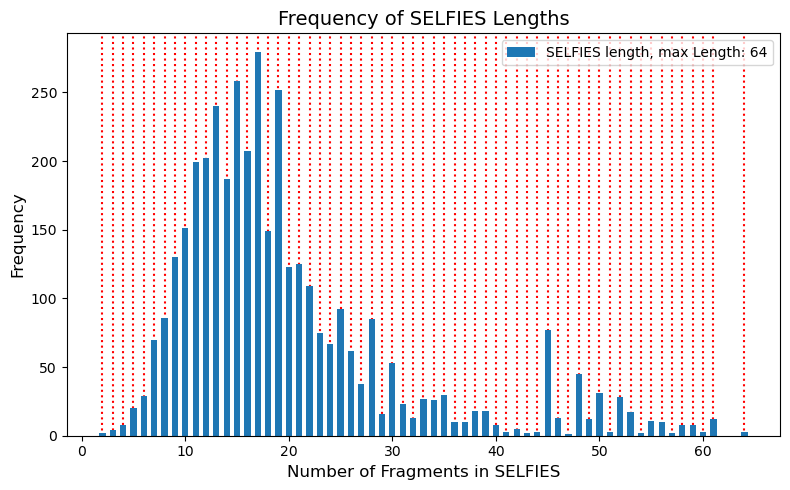

In [14]:
# create a bar chart for the frequencies
max_length = max(length_frequencies.keys())
plt.figure(figsize=(8, 5))
bars = plt.bar(length_frequencies.keys(), length_frequencies.values(), width=0.6, label=f'SELFIES length, max Length: {max_length}')

# Add thin vertical dotted lines at each x position where there's a bar
for bar in bars:
    if bar.get_height() > 0:  # Only add a line where there's a bar
        plt.axvline(x=bar.get_x() + bar.get_width() / 2, color='red', linestyle='dotted', zorder=0)
        

min_length = 0
plt.xticks(range(min_length, max_length + 1, 10))
plt.xlabel('Number of Fragments in SELFIES', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of SELFIES Lengths', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Remove the SELFIES longer than 60. 60 will be the maximum length of the SELFIES

In [15]:
MAX_SELFIES_LENGTH = int(os.getenv("MAX_SELFIES_LENGTH"))
MAX_SELFIES_LENGTH

60

In [16]:
# remove rows with SELFIES longer than 60
cleaned_df_selfies_cropped = cleaned_df_selfies[cleaned_df_selfies["SELFIES"].apply(lambda x: len(x.split("][")) <= MAX_SELFIES_LENGTH)].reset_index(drop=True)
print(cleaned_df_selfies_cropped.shape)
print(f'{cleaned_df_selfies.shape[0]-cleaned_df_selfies_cropped.shape[0]} rows removed')

(5990, 610)
17 rows removed


In [17]:
cleaned_df_selfies_cropped

,Name,Form,Mw,Cas,mz1,mz2,mz3,mz4,mz5,mz6,...,mz597,mz598,mz599,mz600,Filter_Form,SMILES,Arom,Filter,filter,SELFIES
0,"2-Pentanone, 3-ethyl-3-methyl-",C8H16O,128,19780-65-5,0,0,0,0,0,0,...,0,0,0,0,True,CCC(C)(CC)C(C)=O,0,1,1,[C][C][C][Branch1][C][C][Branch1][Ring1][C][C]...
1,3-Methyl-3-hexen-2-ol,C7H14O,114,76966-27-3,0,0,0,0,0,0,...,0,0,0,0,True,CCC=C(C)C(C)O,0,1,1,[C][C][C][=C][Branch1][C][C][C][Branch1][C][C][O]
2,"Hexane, 1-(3-butenyloxy)-",C10H20O,156,107995-55-1,0,0,0,0,0,0,...,0,0,0,0,True,CCCCCCOCCC=C,0,1,1,[C][C][C][C][C][C][O][C][C][C][=C]
3,"2-Hexanone, 3,3-dimethyl-",C8H16O,128,26118-38-7,0,0,0,0,0,0,...,0,0,0,0,True,CCCC(C)(C)C(C)=O,0,1,1,[C][C][C][C][Branch1][C][C][Branch1][C][C][C][...
4,"4-Methyl-1,6-heptadien-4-ol",C8H14O,126,25201-40-5,0,0,0,0,0,0,...,0,0,0,0,True,CC(O)(CC=C)CC=C,0,1,1,[C][C][Branch1][C][O][Branch1][Ring2][C][C][=C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,"Furan, 2,5-dihydro-3-methyl-",C5H8O,84,1708-31-2,0,17,0,0,0,0,...,0,0,0,0,True,CC1=CCOC1,0,1,1,[C][C][=C][C][O][C][Ring1][Branch1]
5986,"Butane, 1-(ethenyloxy)-",C6H12O,100,111-34-2,0,0,0,0,0,0,...,0,0,0,0,True,CCCCOC=C,0,1,1,[C][C][C][C][O][C][=C]
5987,"3-Heptanone, 5-methyl-",C8H16O,128,541-85-5,0,0,0,0,0,0,...,0,0,0,0,True,CCC(C)CC(=O)CC,0,1,1,[C][C][C][Branch1][C][C][C][C][=Branch1][C][=O...
5988,Acetaldehyde,C2H4O,44,75-07-0,0,0,0,0,0,0,...,0,0,0,0,True,CC=O,0,1,1,[C][C][=O]


## Featurize the SELFIES

In [18]:
selfies_group_dict

{'[nop]': 0,
 '[C]': 1,
 '[Branch1]': 2,
 '[Ring1]': 3,
 '[=O]': 4,
 '[=C]': 5,
 '[O]': 6,
 '[Ring2]': 7,
 '[=Branch1]': 8,
 '[#C]': 9,
 '[/C]': 10,
 '[#Branch1]': 11,
 '[\\C]': 12,
 '[Branch2]': 13,
 '[C@@H1]': 14,
 '[C@@]': 15,
 '[C@H1]': 16,
 '[CH1]': 17,
 '[=CH0]': 18,
 '[=N]': 19,
 '[=Branch2]': 20,
 '[#Branch2]': 21,
 '[CH2]': 22,
 '[\\-Ring1]': 23,
 '[S]': 24,
 '[C@]': 25,
 '[N]': 26,
 '[P]': 27,
 '[\\C@@H1]': 28,
 '[/O]': 29,
 '[=CH1]': 30,
 '[=CH2]': 31,
 '[CH0]': 32,
 '[/C@@H1]': 33,
 '[/-Ring1]': 34}

In [19]:
len(selfies_group_dict)

35

In [20]:
hot = sf.batch_selfies_to_flat_hot(cleaned_df_selfies_cropped['SELFIES'].astype(str).tolist(), vocab_stoi=selfies_group_dict, pad_to_len=MAX_SELFIES_LENGTH)

In [21]:
del cleaned_df_selfies, cleaned_df
gc.collect()

0

In [22]:
#hot: list of one hot encoding lists
print(len(hot), len(hot[0]))
#hot[0]

5990 2100


In [23]:
# selfies_emb_df = pd.DataFrame(hot, columns=[f'bit_{i}' for i in range(MAX_SELFIES_LENGTH*len(selfies_group_dict))])
# print('hot deleted')
# selfies_emb_df['SELFIES'] = cleaned_df_selfies_cropped['SELFIES']
# print(selfies_emb_df.shape)
# selfies_emb_df

In [24]:
# df_cols = [f'bit_{i}' for i in range(MAX_SELFIES_LENGTH*len(selfies_group_dict))]
# df_cols.append('SELFIES')
# selfies_emb_df = pd.DataFrame(columns=df_cols)
# for encoding in tqdm(range(len(hot))):
#     row = hot[encoding]
#     row.append(cleaned_df_selfies_cropped.iloc[encoding]['SELFIES'])
#     selfies_emb_df.loc[encoding] = row

In [25]:
# define the columns for the dataframe
df_cols = [f'bit_{i}' for i in range(MAX_SELFIES_LENGTH * len(selfies_group_dict))]
df_cols.append('SELFIES')

# batch size to create dataframes
batch_size = 5000

# initialize an empty list to hold rows temporarily
temp_rows = []

# a list to store dataframe batches
dataframes = []

#selfies_emb_df = pd.DataFrame(columns=df_cols)

# iterate over the encodings and process each row
for encoding in tqdm(range(len(hot))):

    # create the row from hot and append 'SELFIES' value
    row = hot[encoding]
    row.append(cleaned_df_selfies_cropped.iloc[encoding]['SELFIES'])

    # selfies_emb_df.loc[encoding] = row
        
    # add the row to the temporary list
    temp_rows.append(row)
    
    # when the batch is full, convert it to a DataFrame and store it
    if len(temp_rows) == batch_size:
        batch_df = pd.DataFrame(temp_rows, columns=df_cols)
        dataframes.append(batch_df)
        temp_rows = []  # reset the temporary list to save memory

# handle any remaining rows after the loop ends
if temp_rows:
    batch_df = pd.DataFrame(temp_rows, columns=df_cols)
    dataframes.append(batch_df)

del hot, temp_rows
gc.collect()

# concatenate all batch dataframes to create the final dataframe
selfies_emb_df = pd.concat(dataframes, ignore_index=True)

selfies_emb_df.to_pickle(f'{os.getcwd()}/one_hot_selfies_encoding.pkl')
print('one_hot_selfies_encoding.pkl saved')

# display the resulting dataframe
print(selfies_emb_df.shape)
selfies_emb_df.head()


100%|██████████| 5990/5990 [00:10<00:00, 594.30it/s] 


one_hot_selfies_encoding.pkl saved
(5990, 2101)


,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_2091,bit_2092,bit_2093,bit_2094,bit_2095,bit_2096,bit_2097,bit_2098,bit_2099,SELFIES
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[C][C][C][Branch1][C][C][Branch1][Ring1][C][C]...
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[C][C][C][=C][Branch1][C][C][C][Branch1][C][C][O]
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[C][C][C][C][C][C][O][C][C][C][=C]
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[C][C][C][C][Branch1][C][C][Branch1][C][C][C][...
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[C][C][Branch1][C][O][Branch1][Ring2][C][C][=C...


In [26]:
len(selfies_group_dict)

35

## Remove duplicates

In [27]:
# selfies_emb_unique_df = selfies_emb_df.drop_duplicates().reset_index(drop=True)
# print(selfies_emb_unique_df.shape)
# selfies_emb_unique_df

## Save the featurized SELFIES into a PKL

In [28]:
# selfies_emb_unique_df.to_csv(f'{base}/Dataset/Embeddings/{os.getenv("SELFIES_EMBEDDING")}', index=False)
# print(f'Saved the SELFIES embeddings into {base}/Dataset/Embeddings/{os.getenv("SELFIES_EMBEDDING")}')

# Combine the SELFIES embeddings with the cleaned data

In [29]:
ms_emb_df = pd.concat([cleaned_df_selfies_cropped, selfies_emb_df.drop(columns=['SELFIES'])], axis=1)
print(ms_emb_df.shape)
ms_emb_df

(5990, 2710)


,Name,Form,Mw,Cas,mz1,mz2,mz3,mz4,mz5,mz6,...,bit_2090,bit_2091,bit_2092,bit_2093,bit_2094,bit_2095,bit_2096,bit_2097,bit_2098,bit_2099
0,"2-Pentanone, 3-ethyl-3-methyl-",C8H16O,128,19780-65-5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3-Methyl-3-hexen-2-ol,C7H14O,114,76966-27-3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Hexane, 1-(3-butenyloxy)-",C10H20O,156,107995-55-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"2-Hexanone, 3,3-dimethyl-",C8H16O,128,26118-38-7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"4-Methyl-1,6-heptadien-4-ol",C8H14O,126,25201-40-5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,"Furan, 2,5-dihydro-3-methyl-",C5H8O,84,1708-31-2,0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5986,"Butane, 1-(ethenyloxy)-",C6H12O,100,111-34-2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5987,"3-Heptanone, 5-methyl-",C8H16O,128,541-85-5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5988,Acetaldehyde,C2H4O,44,75-07-0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Separate X and y

In [30]:
spectra_columns = [col for col in ms_emb_df.columns if 'mz' in col]
X = ms_emb_df[spectra_columns]
if NORMALIZE_SPECTRA:
    X = X / 999
print(X.shape)
X

(5990, 600)


,mz1,mz2,mz3,mz4,mz5,mz6,mz7,mz8,mz9,mz10,...,mz591,mz592,mz593,mz594,mz595,mz596,mz597,mz598,mz599,mz600
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,0,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
embedding_columns = [col for col in ms_emb_df.columns if 'bit_' in col]
y = ms_emb_df[embedding_columns]
print(y.shape)
y

(5990, 2100)


,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_2090,bit_2091,bit_2092,bit_2093,bit_2094,bit_2095,bit_2096,bit_2097,bit_2098,bit_2099
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5986,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5987,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5988,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Separation into train and test

In [32]:
X_train, X_test, y_train, y_test = NNUtils.divide_big_train_and_test_data(X, y)

Splitting data into chunks: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


In [33]:
selfies_test = ms_emb_df.loc[X_test.index, 'SELFIES']
selfies_test.head()

3268    [C][C][C][Branch1][Ring1][C][C][C][=Branch1][C...
3066    [C][C][Branch1][C][C][C][=C][C][C][Branch1][C]...
1832    [C][C][C][C][C][C][C][C][C][Branch1][Ring1][C]...
5069    [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][...
3375    [C][C][Branch1][C][C][C][C][C][Branch1][Ring1]...
Name: SELFIES, dtype: object

In [34]:
print(X_train.shape)
X_train.head()

(4792, 600)


,mz1,mz2,mz3,mz4,mz5,mz6,mz7,mz8,mz9,mz10,...,mz591,mz592,mz593,mz594,mz595,mz596,mz597,mz598,mz599,mz600
3807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
print(y_train.shape)
y_train.head()

(4792, 2100)


,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_2090,bit_2091,bit_2092,bit_2093,bit_2094,bit_2095,bit_2096,bit_2097,bit_2098,bit_2099
3807,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5695,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5956,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1964,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
print(X_test.shape)
X_test.head()

(1198, 600)


,mz1,mz2,mz3,mz4,mz5,mz6,mz7,mz8,mz9,mz10,...,mz591,mz592,mz593,mz594,mz595,mz596,mz597,mz598,mz599,mz600
3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print(y_test.shape)
y_test.head()

(1198, 2100)


,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_2090,bit_2091,bit_2092,bit_2093,bit_2094,bit_2095,bit_2096,bit_2097,bit_2098,bit_2099
3268,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3066,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1832,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5069,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3375,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
selfies_test.reset_index(drop=True, inplace=True)

In [39]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
input_size, output_size

(600, 2100)

In [40]:
X_train.to_pickle(os.getenv('X_TRAIN'))
print(f"{os.getenv('X_TRAIN')} saved")
y_train.to_pickle(os.getenv('Y_TRAIN'))
print(f"{os.getenv('Y_TRAIN')} saved")
X_test.to_pickle(os.getenv('X_TEST'))
print(f"{os.getenv('X_TEST')} saved")
y_test.to_pickle(os.getenv('Y_TEST'))
print(f"{os.getenv('Y_TEST')} saved")
selfies_test.to_pickle(os.getenv('SELFIES_X_TEST'))
print(f"{os.getenv('SELFIES_X_TEST')} saved")

X_train.pkl saved
y_train.pkl saved
X_test.pkl saved
y_test.pkl saved
selfies_X_test.pkl saved


In [41]:
print('done')

done
